# Tellen

We gaan per document, en per pagina het volgende tellen

* aantal text velden
* aantal plaatjes
* aantal woorden
* aantal letters

In [111]:
import pandas as pd
import re
%matplotlib inline
from lxml import etree
from collections import defaultdict
import seaborn as sns
import numpy as np

In [20]:
# read xml

vb = '../CovidWOBPDFs/8b8890d6058f24465456cc410f4262ae_documenten.xml'
root = etree.parse(vb)
 
pages = root.xpath('//page')
len(pages)

72

In [85]:
def tellenPerCorpus(L):
    DB=dict()
    for f in L:
        root = etree.parse(f)
        pages = root.xpath('//page')
        DB[f]=tellenPerfile(pages)
    return DB

def tellenPerfile(pages):
    DB=dict()
    for page in pages:
        # aantal text
        nrtext= len(page.xpath('text'))
        # aantal plaatjes
        nrimg=len(page.xpath('image'))
        # aantal woorden
        nrwords= sum(len(re.split(r'\W+',text.strip())) for text in page.xpath('text/text()')
                    if text.strip())
        # aantal karakters zonder spatie
        nrchars= sum(len(re.sub(r'\s','',text)) for text in page.xpath('text/text()')
                    if text.strip())
        DB[int(page.xpath('@number')[0] )]= {'text':nrtext,
                                             'img':nrimg,
                                            'nrwords':nrwords,
                                            'nrchars': nrchars}
    return DB

# test
#tellenPerfile(pages)




In [86]:
%%time 
%cd ../CovidWOBPDFs/
L=!ls *.xml
AllCounts=tellenPerCorpus(L)

/Users/admin/surfdrive/onderwijs/Afstudeerders/20212022/DaanKuypers/DocumentSplitting/CovidWOBPDFs
CPU times: user 29.5 s, sys: 2.33 s, total: 31.8 s
Wall time: 33.7 s


In [88]:
# data frame met multiindex (filenaam, pagina nr)

df =pd.DataFrame.from_dict({(i,j): AllCounts[i][j] 
                           for i in AllCounts.keys() 
                           for j in AllCounts[i].keys()},
                       orient='index')
df.head(100)

text  img  nrwords  \
0068ed0b40cca6270f857d2614cc63c0_besluit.xml       1     74    2      309   
                                                   2     65    0      390   
                                                   3     65    0      447   
0068ed0b40cca6270f857d2614cc63c0_document.xml      1     83    0      192   
0272cdb141e62321341591f0959794a2_derde-deelbesl... 1      0    1        0   
...                                                     ...  ...      ...   
0272cdb141e62321341591f0959794a2_wob-documenten... 78   491   12      711   
                                                   79   433   12      677   
                                                   80   426   12      690   
                                                   81   340   12      530   
                                                   82   496   12      729   

                                                       nrchars  
0068ed0b40cca6270f857d2614cc63c0_besluit.xml       1      1467  
                                                   2      1942  
                                                   3      2471  
0068ed0b40cca6270f857d2614cc63c0_document.xml      1      1050  
0272cdb141e62321341591f0959794a2_derde-deelbesl... 1         0  
...                                                        ...  
0272cdb141e62321341591f0959794a2_wob-documenten... 78     3755  
                                                   79     3788  
                                                   80     3686  
                                                   81     2830  
                                                   82     3471  

[100 rows x 4 columns]

In [141]:
# geen multi-index df meer

df.index.names=['file','page']
df2= df.reset_index(1)
df2.head()

,page,text,img,nrwords,nrchars
file,,,,,
0068ed0b40cca6270f857d2614cc63c0_besluit.xml,1,74,2,309,1467
0068ed0b40cca6270f857d2614cc63c0_besluit.xml,2,65,0,390,1942
0068ed0b40cca6270f857d2614cc63c0_besluit.xml,3,65,0,447,2471
0068ed0b40cca6270f857d2614cc63c0_document.xml,1,83,0,192,1050
0272cdb141e62321341591f0959794a2_derde-deelbesluit-aantal-aanwezigen-in-kerken.xml,1,0,1,0,0


# Overzichten per file/document

## Number of pages

count     328.000000
mean       99.317073
std       337.768124
min         1.000000
25%         5.000000
50%        19.500000
75%        80.000000
max      4910.000000
Name: page, dtype: float64

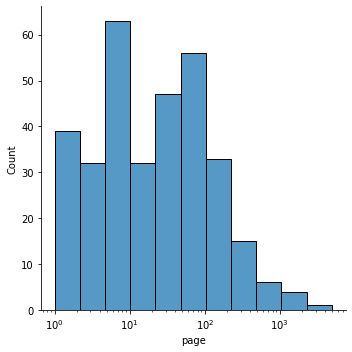

In [133]:
sns.displot((df2.groupby('file')['page'].count()), log_scale=(True,False) );
df2.groupby('file')['page'].count().describe()

# Nr of andere dingen

* Ik tel steeds 1 erbij op voor de log schaal (dus die aparte staaf links zijn het aantal nulletjes)
* text, woorden en karakgters zijn netjes lognormaal verdeeld. images niet.

,text,img,nrwords,nrchars
count,328.0,328.0,328.0,328.0
mean,11889.0,745.0,21056.0,97645.0
std,63527.0,4159.0,93762.0,445672.0
min,0.0,0.0,0.0,0.0
25%,302.0,2.0,576.0,2698.0
50%,1220.0,20.0,3249.0,16412.0
75%,5529.0,136.0,16436.0,70174.0
max,862263.0,63393.0,1256710.0,6026379.0


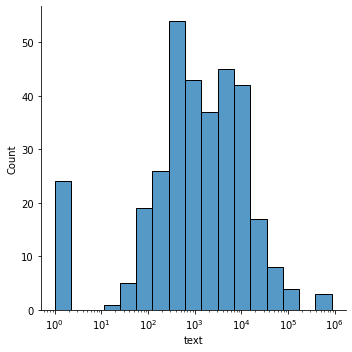

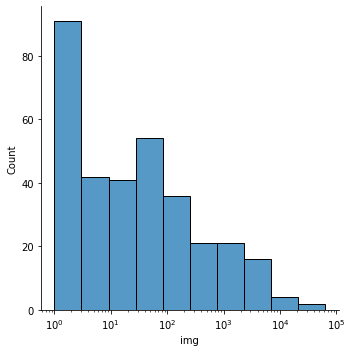

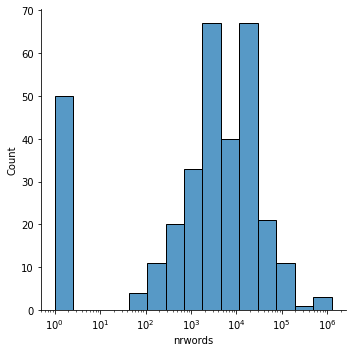

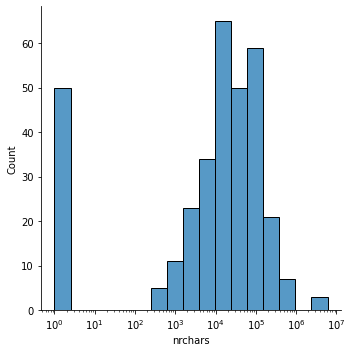

In [140]:
tellingen_per_doc= df2[['text', 'img', 'nrwords', 'nrchars']].groupby('file').sum()

for k in ['text', 'img', 'nrwords', 'nrchars']:
    sns.displot(tellingen_per_doc[k]+1, log_scale=(True,False)  );
#sns.displot(tellingen_per_doc.text+0.1, log_scale=(True,False)  );
tellingen_per_doc.describe().round(0)

# Overzicht per pagina

* 32.5K paginas
* 8519 zonder ook maar 1 karakter
* 253 daarvan hebben ook geen image, en de meeste dus ook geen text elementen

## verdelingen

* img heeft de neiging er 12 per pagina te maken
* andere met een grote piek bij de 0, en dan tsja, lognormaal , met wa meer waardes in de kleine getallen
    

In [158]:
df.describe()

,text,img,nrwords,nrchars
count,32576.000000,32576.000000,32576.000000,32576.000000
mean,119.707361,7.497943,212.012064,983.169235
std,156.657084,108.446257,237.802371,1088.927867
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000
50%,56.000000,5.000000,142.000000,635.000000
75%,188.000000,13.000000,356.000000,1648.000000
max,2838.000000,18816.000000,3028.000000,13477.000000


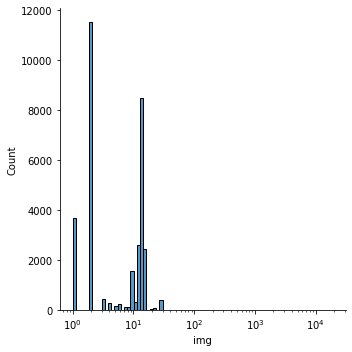

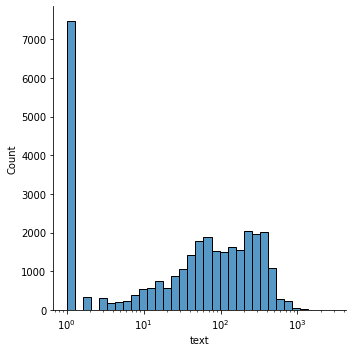

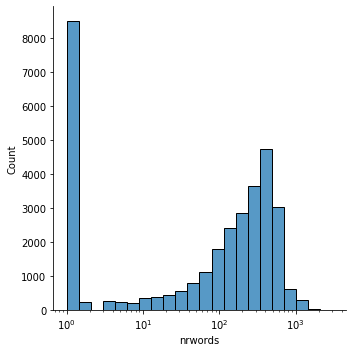

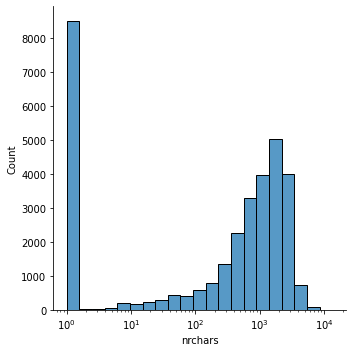

In [170]:
for k in [ 'img',  'text', 'nrwords', 'nrchars']:
    sns.displot(df[k]+1, log_scale=(True,False)   );

In [161]:
df[df.nrchars==0][df.img==0].describe()

/Users/admin/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,text,img,nrwords,nrchars
count,253.000000,253.0,253.0,253.0
mean,0.407115,0.0,0.0,0.0
std,2.086490,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0
25%,0.000000,0.0,0.0,0.0
50%,0.000000,0.0,0.0,0.0
75%,0.000000,0.0,0.0,0.0
max,20.000000,0.0,0.0,0.0


# Documenten zonder woorden

* bevatten meestal maar 1 image, namelijk van de hele pagina.
* Ik heb er 1 geprobeerd met tessaract en die haalde alles er keurig uit.

In [149]:
df2[df2.nrchars==0].img.describe()

count    8519.000000
mean        4.159174
std         7.792464
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       107.000000
Name: img, dtype: float64

In [155]:
# 50 files zonder 1 woord, zelfs geen karakter

len(df2[df2.groupby('file')['nrchars'].sum()==0].index.unique())

/Users/admin/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


50

In [157]:
# 1689 paginas

df2[df2.groupby('file')['nrchars'].sum()==0]

/Users/admin/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,page,text,img,nrwords,nrchars
file,,,,,
0335b3f498dbbd7c537ad23abe8c08dc_2-inventarislijst-wob-verzoek-11-08-2021-inzake-het-europees-herstelfonds.xml,1,0,1,0,0
0335b3f498dbbd7c537ad23abe8c08dc_2-inventarislijst-wob-verzoek-11-08-2021-inzake-het-europees-herstelfonds.xml,2,0,1,0,0
0335b3f498dbbd7c537ad23abe8c08dc_2-inventarislijst-wob-verzoek-11-08-2021-inzake-het-europees-herstelfonds.xml,3,0,1,0,0
0335b3f498dbbd7c537ad23abe8c08dc_2-inventarislijst-wob-verzoek-11-08-2021-inzake-het-europees-herstelfonds.xml,4,0,1,0,0
0335b3f498dbbd7c537ad23abe8c08dc_2-inventarislijst-wob-verzoek-11-08-2021-inzake-het-europees-herstelfonds.xml,5,0,1,0,0
...,...,...,...,...,...
fa1882d312db1389abfca529f31c3408_wob-documenten.xml,94,0,1,0,0
fa1882d312db1389abfca529f31c3408_wob-documenten.xml,95,0,1,0,0
fa1882d312db1389abfca529f31c3408_wob-documenten.xml,96,0,1,0,0
